# Lesson 0018 - MNIST Classification Convolutional Neural Network
In lessons [0014](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0014_mnist_classification_neural_network.ipynb), [0015](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0015_mnist_classification_deep_neural_network.ipynb), [0016](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0016_mnist_classification_deep_neural_network_2.ipynb) and [0017](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0017_mnist_classification_deep_neural_network_3.ipynb) we approached the task of classifying the MNIST data set with neural networks of varying depth.<br>
Since we realized in the last lesson, that we cannot perform better than in [lesson 0016](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0016_mnist_classification_deep_neural_network_2.ipynb) using the standard deep neural network approach, we now turn to [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network).<br>
We start by stealing the code from [lesson 0014](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0014_mnist_classification_neural_network.ipynb) to prepare the data. Please consider, the in [lesson 0014](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0014_mnist_classification_neural_network.ipynb) the image data were flattened, whereas for the convolutional neural networks, we actually keep the image format.

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
( train_x, train_y ),( test_x, test_y ) = tf.keras.datasets.mnist.load_data()

In [3]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [4]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [5]:
mu = np.mean( train_x )

sigma = np.std( train_x )



train_x = ( train_x - mu ) / sigma

test_x = ( test_x - mu ) / sigma

In [6]:
train_y_2 = np.zeros( shape = [ 60000, 10 ] )

test_y_2 = np.zeros( shape = [ 10000, 10 ] )




for i in range( 60000 ):
    
    train_y_2[ i, train_y[ i ] ] = 1.0
    
    
for i in range( 10000 ):
    
    test_y_2[ i, test_y[ i ] ] = 1.0
    




train_y = train_y_2

test_y = test_y_2

Now that we have prepared the data, we start with considering, what convolutional neural networks actually are.<br>
The basic idea of a convolutional neural network is to apply one filter to the data.<br>
In our case, the input data are images, therefore it is safe to assume, that nearby data points are more dependent on each each other than data points, that are far apart.<br>
Therefore, we can create a filter that considers this: let $I_{i,j}$ be the pixel information a location $\left(i,j\right)$, then an image might look like $\left(\begin{array}{ccccc}I_{1,1}&I_{1,2}&I_{1,3}&I_{1,4}&\dots\\I_{2,1}&I_{2,2}&I_{2,3}&I_{2,4}&\dots\\I_{3,1}&I_{3,2}&I_{3,3}&I_{3,4}&\dots\\I_{4,1}&I_{4,2}&I_{4,3}&I_{4,4}&\dots\\\vdots&\vdots&\vdots&\vdots&\vdots\end{array}\right)$, then a filter might look like $\left(\begin{array}{ccc}F_{1,1}&F_{1,2}&F_{1,3}\\F_{2,1}&F_{2,2}&F_{2,3}\\F_{3,1}&F_{3,2}&F_{3,3}\end{array}\right)$ where $F_{i,j}$ is the filter information at $\left(i,j\right)$. We apply this filter by multiplying the information in the image at a certain position with the filter at a certain position and then sum over the invdividual products. This means $result_{x,y}=\sum_{i=1}^{F_{i}}\sum_{j=1}^{F_{j}}I_{x+i-1,y+j-1}F_{i,j}$. Here $x$ and $y$ denote the the starting coordinates in the image where we begin to apply the filter. $F_{i}$ is the filter size in the vertical dimension, and $F_{j}$ is the filter size in the horizontal dimension.<br>
For the choice of $x$ and $y$ exist various strategies.<br> 
__Full Padding__ means, we choose $x$ and $y$ in a fashion, so that every pixel of the filter is applied to every pixel in the image. Therefore __Full Padding__ results in a bigger image. Consider the case, where we apply a $3*3$ filter to an image. If we want to apply $F_{3,3}$ to $I_{1,1}$, we have to choose $x=y=-1$. This means, for __Full Padding__, we map a $n*n$ image to a $\left(n+2\right)*\left(n+2\right)$ image, if we apply a $3*3$ filter.<br>
__Same Padding__ means, that we choose $x$ and $y$ in a fashion, so that the resulting image is again $n*n$.<br>
In __Valid Padding__ we only consider computations with existing pixels, therefore applying a $3*3$ filter to a $n*n$ image results in a $\left(n-2\right)*\left(n-2\right)$ image.<br>
This raises the question how to deal with undefined pixel which appear in __Full Padding__ or __Same Padding__. There are two strategies: one is to assume, that the pixel values outside the image are all $0$. The other strategy is to copy the information of the pixels that are the border of the image.<br>
Now that we have introduced the filter, let us think about how to apply it. We might start at $\left(x,y\right)=\left(1,1\right)$, then continue at $\left(x,y\right)=\left(1,2\right)$ and so on until we reached $\left(x,y\right)=\left(1,n\right)$. Then we might continue with $\left(x,y\right)=\left(2,1\right)$. This gliding uses __strides__ of size $\left(1,1\right)$. We might define other strides like $\left(1,5\right)$.<br>
__Max Pooling__ is the idea of considering an array of pixel, and then choosing only the greatest of these pixels. If the area considered is greater than $1$ pixel, this leads to a reduction of the image size while maintining the greatest values.<br>
Now we start with implementing the convolutional neural network. We can use [conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d) to define the convolutional layer and [max_pooling2d](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d) for __Max Pooling__.<br>
We create our convolutional net the following way: first, there is a convolutional layer with $32$ filters of size $5*5$ using __valid padding__. This means, that the $28*28$ input image is mapped to $32$ $24*24$ images. Then, we apply __Max Pooling__ of size $2$ and __strides__ $\left(2,2\right)$, thereby, we map the $32$ $24*24$ images to $32$ $12*12$ images. Then, we do exactly the same again. Thereby, we reduce the image to $32$ $4*4$ images. We transform these data into a flat layer using [flatten](https://www.tensorflow.org/api_docs/python/tf/layers/flatten).<br>
Using code from [lesson 0014](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0014_mnist_classification_neural_network.ipynb), we feed this flattened data into the output layer.<br>
We train this model for $100000$ iterations with a learning rate of $0.001$ on $100$ randomly drawn training data.

In [7]:
x_tf = tf.placeholder( tf.float32, shape = [ None, 28, 28, 1 ] )

y_tf = tf.placeholder( tf.float32, shape = [ None, 10 ] )




conv1 = tf.layers.conv2d( x_tf, filters = 32, kernel_size = [ 5, 5 ] )

max1 = tf.layers.max_pooling2d( conv1, pool_size = [ 2, 2 ], strides = [ 2, 2 ] )

conv2 = tf.layers.conv2d( max1, filters = 32, kernel_size = [ 5, 5 ] )

max2 = tf.layers.max_pooling2d( conv2, pool_size = [ 2, 2 ], strides = [ 2, 2 ])

flat = tf.layers.flatten( max2 )





W_tf = tf.Variable( tf.truncated_normal( [ 512, 10 ] ) )

b_tf = tf.Variable( tf.truncated_normal( [ 10 ] ) )

output = tf.nn.leaky_relu( tf.matmul( flat, W_tf ) + b_tf )




cross_entropy = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2( logits = output, labels = y_tf ) )




gd = tf.train.GradientDescentOptimizer( 0.001 ).minimize( cross_entropy )



hit = tf.equal( tf.argmax( output, 1 ), tf.argmax( y_tf, 1 ) )



accuracy = 100 * tf.reduce_mean( tf.cast( hit, tf.float32 ) )

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.


In order to deliver data that are suitable with respect to their formating, we reshape our data using [reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html).

In [8]:
sess = tf.Session()

progress_train = []

progress_train_current = []

progress_test = []




train_x_r = np.reshape( train_x, newshape = [ 60000, 28, 28, 1 ] )

test_x_r = np.reshape( test_x, newshape = [ 10000, 28, 28, 1 ] )
 
    
    
sess.run( tf.global_variables_initializer() )
        
for i in range( 100000 ):
                
    random_integers = np.random.choice( range( 60000 ), 100, replace = False )
                
    local_x = train_x[ random_integers, :, : ]
    
    local_y = train_y[ random_integers, : ]
    
    local_x = np.reshape( local_x, newshape = [ 100,28, 28, 1 ] )
        
    sess.run( gd, feed_dict = { x_tf : local_x, y_tf : local_y } )
        
    progress_train.append( sess.run( accuracy, feed_dict = { x_tf : train_x_r, y_tf : train_y } ) )
        
    progress_train_current.append( sess.run( accuracy, feed_dict = { x_tf : local_x, y_tf : local_y } ) )
        
    progress_test.append( sess.run( accuracy, feed_dict = { x_tf : test_x_r, y_tf : test_y } ) )

Text(0, 0.5, 'Accuracy (%)')

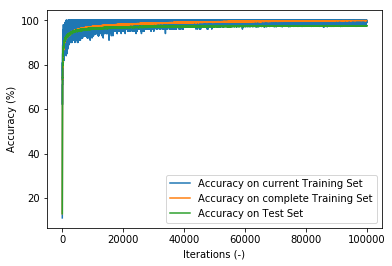

In [9]:
plt.plot( progress_train_current, label = 'Accuracy on current Training Set' )

plt.plot( progress_train, label = 'Accuracy on complete Training Set' )

plt.plot( progress_test, label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

Text(0, 0.5, 'Accuracy (%)')

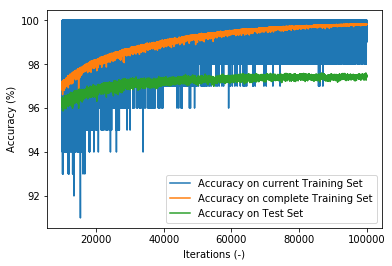

In [10]:
plt.plot( range( 10000, 100000), progress_train_current[ 10000 : 100000 ], label = 'Accuracy on current Training Set' )

plt.plot( range( 10000, 100000), progress_train[ 10000 : 100000 ], label = 'Accuracy on complete Training Set' )

plt.plot( range( 10000, 100000), progress_test[ 10000 : 100000 ], label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

Text(0, 0.5, 'Accuracy (%)')

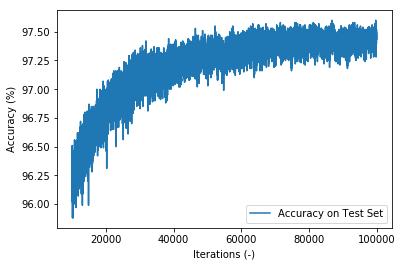

In [11]:
plt.plot( range( 10000,100000), progress_test[ 10000 : 100000 ], label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

We steal code from [lesson 0015](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0015_mnist_classification_deep_neural_network.ipynb) to save the model:

In [12]:
saver = tf.train.Saver()

saver.save( sess, 
           "C:\\Users\\rhopi\\OneDrive\\Desktop\\python dev\\github\\lesson_0018\\convolutional_neural_network_32_32" )

'C:\\Users\\rhopi\\OneDrive\\Desktop\\python dev\\github\\lesson_0018\\convolutional_neural_network_32_32'

In [13]:
sess.close()

We notice, that after iteration $70000$, the performance on the test set hardly improves.<br>
Also, the performance on the complete training set approaches $100\%$, so we assume, that this model can hardly perform any better.<br>
We also notice, that this model takes less space on the harddisk than the model from [lesson 0015](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0015_mnist_classification_deep_neural_network.ipynb). This is due to the fact, that there, we only considered fully connected layers where each node is connected to every node of the following layer which results in many weights. In the case of the convolutional neural network, we have only one fully connected layer at the end, and before that, we only have $64$ filters with $25$ weights each.<br>
Class dismissed.